# Preprocessing

This notebook does the preprocessing for the dataset.

1. The bounding boxes and labels are extracted from the annotation files
2. The image, bounding box and label are grouped and accumulated in a list
3. For training, a train-validation split of 80/20 is done by shuffling the extracted training data and splitting
4. These split data is saved into a CSV file for a `CSVGenerator` in the training section to consume

In [1]:
import glob
import csv
import numpy as np

In [2]:
def extract_box(path):
    """extract_box
    Extract annotation box positions for each labels from VIVA hand dataset.
    output is a list of tuples.

    :param path: text file path
    """

    with open(path) as temp:
        output = []

        for i, line in enumerate(temp):

            if i != 0 and line:
                label, x_1, y_1, x_off, y_off, *_ = line.split()
                pt_1 = (int(x_1), int(y_1))
                pt_2 = (pt_1[0] + int(x_off), (pt_1[1] + int(y_off)))
                output.append((label, pt_1, pt_2))

    return output

In [3]:
def create_csv(image_dir, annotation_dir, csv_out_path, val_out_path=None, val_split=None):
    image_paths = sorted(glob.glob(image_dir + '*'))
    annotations_paths = sorted(glob.glob(annotation_dir + '*'))

    # each image can have up to 4 hand bboxes
    rows = []
    for image_path, annotations_path in zip(image_paths, annotations_paths):
            annotations = extract_box(annotations_path)
            for annotation in annotations:
                # annotation [label, (x1, y1), (x2, y2)]
                # save as image,x1,y2,x2,y2,label
                rows.append([image_path,
                             annotation[1][0], annotation[1][1],
                             annotation[2][0], annotation[2][1],
                             annotation[0]])
    if val_split:
        # shuffle and split
        np.random.shuffle(rows)
        val_size = int(len(rows) * val_split)
        val_rows = rows[:val_size]
        with open('./data/validation.csv' if val_out_path is None else val_out_path, 'w') as csv_file:
            writer = csv.writer(csv_file)
            for row in val_rows:
                writer.writerow(row)
        rows = rows[val_size:]

    with open(csv_out_path, 'w') as csv_file:
            writer = csv.writer(csv_file)
            for row in rows:
                writer.writerow(row)

In [4]:
# this is the root directory where the training data is extracted
data_dir = '/media/appsyoon/New Volume/Machine Learning/data/'
# training data path
train_dir = data_dir + 'detectiondata/train/'
train_image_dir = train_dir + 'pos/'
train_annotation_dir = train_dir + 'posGt/'

out_path = './data/train.csv'

create_csv(train_image_dir, train_annotation_dir, out_path, val_split=0.2)

In [5]:
# the test data images are in the same root dir as training
test_image_dir = data_dir + 'detectiondata/test/pos/'
# but the annotations are downloaded separately and extracted into data_dir/evaluation/
test_annotation_dir = data_dir + 'evaluation/annotations/'

test_out_path = './data/test.csv'

create_csv(test_image_dir, test_annotation_dir, test_out_path)

## Visualization

Some visualization of the training data.

In [6]:
import os
import matplotlib.pyplot as plt

In [7]:
train_annotations_paths = sorted(glob.glob(train_annotation_dir + '*'))

#class names
lh_d_label = 'leftHand_driver'
rh_d_label = 'rightHand_driver'
lh_p_label = 'leftHand_passenger'
rh_p_label = 'rightHand_passenger'

# each image can have up to 4 hand bboxes
lh_d_count = 0
rh_d_count = 0
lh_p_count = 0
rh_p_count = 0

for annotations_path in train_annotations_paths:
    anns = extract_box(annotations_path)
    viewpoint = os.path.splitext(os.path.split(annotations_path)[1])[0].split('_')[-1]
    for ann in anns:
        if ann[0] == lh_d_label:
            lh_d_count += 1
        elif ann[0] == rh_d_label:
            rh_d_count += 1
        elif ann[0] == lh_p_label:
            lh_p_count += 1
        elif ann[0] == rh_p_label:
            rh_p_count += 1

print('Left Hand Driver Bounding Boxes: {}'.format(lh_d_count))
print('Right Hand Driver Bounding Boxes: {}'.format(rh_d_count))
print('Left Hand Passenger Bounding Boxes: {}'.format(lh_p_count))
print('Right Hand Passenger Bounding Boxes: {}'.format(rh_p_count))

Left Hand Driver Bounding Boxes: 4949
Right Hand Driver Bounding Boxes: 5354
Left Hand Passenger Bounding Boxes: 1639
Right Hand Passenger Bounding Boxes: 1287


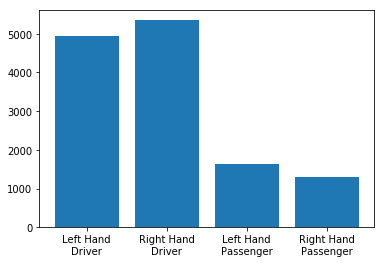

In [8]:
#plot
plt.bar([0, 1, 2, 3], 
        [lh_d_count, rh_d_count, lh_p_count, rh_p_count], 
        tick_label=['Left Hand\nDriver', 'Right Hand\nDriver', 'Left Hand\nPassenger', 'Right Hand\nPassenger'])
plt.savefig('./charts/classes_count.png')
plt.show()

The challenge evaluates on two different levels:

Level-1 (L1): hand instances with minimum height of 70 pixels, only over the shoulder (back) camera view.

- Check height from annotation >= 70
- From image name format `videoID_framenumber_vehicletype_driversubjectID_passengersubjectID_viewpoint.png` viewpoint is 3.

Level-2 (L2): hand instances with minimum height of 25 pixels, all camera views.

- Check height from annotation >= 25

In [9]:
test_annotations_paths = sorted(glob.glob(test_annotation_dir + '*'))

L1 = 0
L2 = 0

for annotations_path in test_annotations_paths:
        anns = extract_box(annotations_path)
        viewpoint = os.path.splitext(os.path.split(annotations_path)[1])[0].split('_')[-1]
        for ann in anns:            
            height = ann[2][1] - ann[1][1]
            if viewpoint == '3' and height >= 70:
                L1 += 1
            
            if height >= 25:
                L2 += 1
                

print('L1: {}'.format(L1))
print('L2: {}'.format(L2))

L1: 6607
L2: 12080
